### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import time
from IPython import display

In [ ]:
tf.__version__

'2.15.0'

### Load and Preprocess Dataset

In [ ]:
(X_train, y_train) , (_,_)= tf.keras.datasets.mnist.load_data() # tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28,28,1).astype('float32') # 1 for black-white
print(X_train.shape)

(60000, 28, 28, 1)


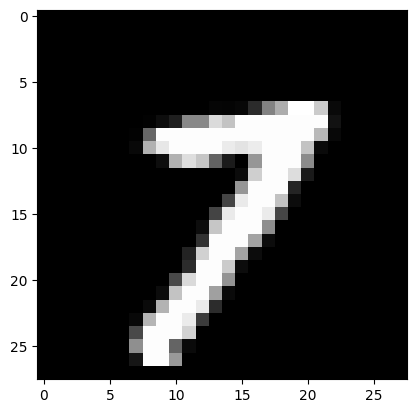

In [ ]:
plt.imshow(X_train[40000], cmap='gray')

NORMALIZE THE DATA

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
buffer_size / batch_size

234.375

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

### BUILD THE GENERATOR

In [ ]:
def build_generator():
  generator = tf.keras.Sequential()

  generator.add(tf.keras.Input(shape = (100))) # noisy data
  generator.add(layers.Dense(units = 7*7*256, use_bias= False)) # 7*7*256 = 12544, bias units is not necessary generator is not a completely CNN trainer.
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())

  generator.add(layers.Reshape((7,7,256)))

  # 7 * 7 * 128
  generator.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())
  # 14 * 14 * 64
  generator.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())

  # 28 * 28 * 1
  generator.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False, activation = 'tanh'))
  generator.summary()

  return generator

In [ ]:
generator = build_generator()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)        

In [ ]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'input_3')>

In [ ]:
noise = tf.random.normal([1, 100])
print(noise)

tf.Tensor(
[[ 2.0272522   0.69920576  0.43585494  0.24203041  0.98393536 -0.38863307
   0.69840276 -0.06181533  0.5467357  -1.5294105   1.0568776   1.0641776
   1.2296458  -0.4079227   0.58946806  0.33319446 -0.12166061 -0.09771361
   0.39131027 -0.15959078 -0.65790737  1.5999496   0.12779757  0.5204202
  -0.49805635  0.8866857  -0.34863576 -1.1548795  -1.4240849   1.320947
  -0.5232273   0.20154737  0.23780866  1.5656348  -1.964592   -2.1007295
  -1.9214604  -1.4727839   0.0431001   0.6476737   1.3167961  -0.25487286
  -0.4864787  -0.20752022  0.87058616 -0.57239276 -1.7926085  -0.8542034
   0.2952496  -1.8650106  -1.5048367   1.194565    0.26573902  0.5230809
  -1.2202604  -0.708528    0.98021084  0.17626071  1.2851532  -0.38671124
   0.00414404 -1.3277669  -0.3275227  -0.01127638  1.2058235   0.3589583
   1.7036583  -0.27810216  1.6552044   0.9862278   1.6098666  -0.08498609
   0.00548844  0.44126335 -0.01095976 -0.65878487 -0.47824967 -0.95535487
  -0.2411687   1.624837    0.784779

In [ ]:
generated_image = generator(noise, training = False)

In [ ]:

generated_image.shape

TensorShape([1, 28, 28, 1])

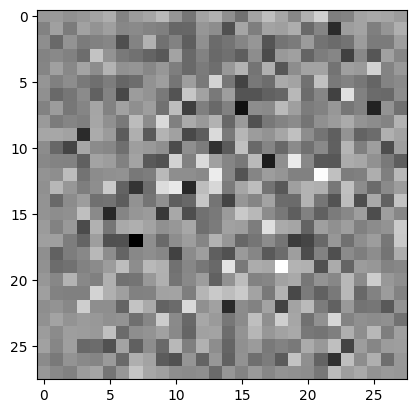

In [ ]:
plt.imshow(generated_image[0, :,:, 0], cmap='gray')

### BUILD THE DISCRIMINATOR

In [ ]:
def build_discriminator():
  discriminator = tf.keras.Sequential()

  generator.add(tf.keras.Input(shape = (28,28,1)))

  # 14 * 14 * 64
  discriminator.add(layers.Conv2D(filters = 64, strides= (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  discriminator.add(layers.LeakyReLU())
  discriminator.add(layers.Dropout(0.3))


  # 7 * 7 * 128
  discriminator.add(layers.Conv2D(filters = 128, strides= (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  discriminator.add(layers.LeakyReLU())
  discriminator.add(layers.Dropout(0.3))

  discriminator.add(layers.Flatten())
  discriminator.add(layers.Dense(1))

  discriminator.summary()

  return discriminator

In [ ]:
discriminator = build_discriminator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [ ]:
discriminator

In [ ]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_2_input')>

In [ ]:
discriminator(generated_image, training =False ) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00071682]], dtype=float32)>

In [ ]:
tf.sigmoid(0.00101214)

<tf.Tensor: shape=(), dtype=float32, numpy=0.500253>

### Error Calculation

In [ ]:
def discriminator_loss(expected_output, fake_output, gradient_penalty ): # expected_output = real_output
  lambda_c = 10
  disc_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(expected_output) + lambda_c * gradient_penalty
  return disc_loss

In [ ]:
def generator_loss(fake_output):
  g_loss = -1 * tf.math.reduce_mean(fake_output)
  return g_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002, beta_1 = 0.5, beta_2 = 0.9)

### Gradient Penalty

In [ ]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1-epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]

  gradients = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradients)
  grad_penalty = tf.math.reduce_mean((gradient_norm -1)**2)
  return grad_penalty


In [ ]:
checkpoint_dir = '/content/training_chechpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'checkpoints')
print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer =generator_optimizer , discriminator_optimizer = discriminator_optimizer, generator = generator, discriminator = discriminator)

/content/training_chechpoints/checkpoints


### TRAINING

In [ ]:
EPOCHS = 100
NOISE_DIMENSION = 100
NUMBER_OF_IMAGES = 16
seed = tf.random.normal([NUMBER_OF_IMAGES, NOISE_DIMENSION])

In [ ]:
print(seed)

tf.Tensor(
[[ 0.42485595 -0.72374004  0.33924887 ... -0.3204969  -0.42734757
  -0.56836474]
 [ 1.1528013  -0.2476148   1.0779622  ...  0.54425347 -0.64257693
   0.36200973]
 [-0.4025757   1.6324903   0.29052243 ... -0.6427619   0.88589925
  -1.027878  ]
 ...
 [ 1.767744    0.37440726 -0.45243096 ... -0.131847    1.150672
   1.3901536 ]
 [-0.16631386  1.2368809   0.949411   ...  0.3258699  -0.65995127
  -0.583878  ]
 [ 0.21574287  1.6333566   1.4431267  ... -1.6247588  -0.844712
  -0.6798136 ]], shape=(16, 100), dtype=float32)


In [ ]:
def train(images):
  noise = tf.random.normal([batch_size, NOISE_DIMENSION])
  discriminator_extra_steps = 3

  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)

      expected_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)

      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0 ,  1.0)
      grad_penalty = gradient_penalty(images, generated_images, epsilon)


      disc_loss = discriminator_loss(expected_output, fake_output,grad_penalty )

    discriminator_gradients = d_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
      generated_images = generator(noise, training = True)
      fake_output = discriminator(generated_images, training = True)

      gen_loss = generator_loss(fake_output)

  generator_gradients = g_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [ ]:
test_images = tf.random.normal([NUMBER_OF_IMAGES, NOISE_DIMENSION])
test_images.shape

TensorShape([16, 100])

In [ ]:
def create_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize=(4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap="gray" )
    plt.axis('off')
  plt.savefig(f'img_epoch_{epoch}')
  plt.show()

In [ ]:
def train_gan(dataset, epochs):
  for epoch in range(epochs):
    print('Epoch: ', epoch+1)
    initial = time.time()
    for images_batch in dataset:
      if len(images_batch) == batch_size:
        train(images_batch)

    create_save_images(generator, epoch+1, seed)

    if (epoch+1)  % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds.'.format(epoch+1, time.time() - initial))

  create_save_images(generator, epochs, seed)
  generator.save('generator.h5')

Epoch:  1


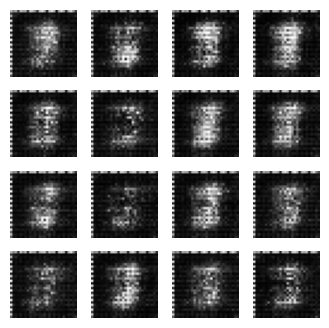

Time taken to process epoch 1 was 64.10737085342407 seconds.
Epoch:  2


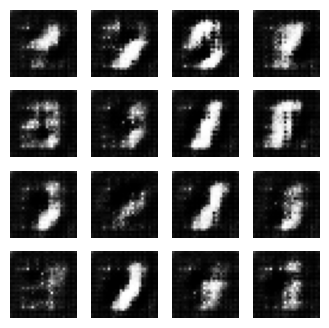

Time taken to process epoch 2 was 62.77399015426636 seconds.
Epoch:  3


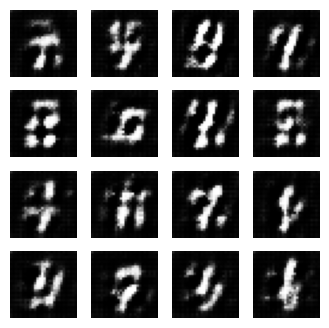

Time taken to process epoch 3 was 82.68877053260803 seconds.
Epoch:  4


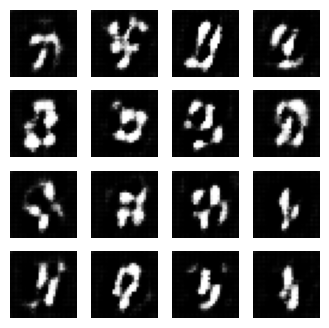

Time taken to process epoch 4 was 82.65988492965698 seconds.
Epoch:  5


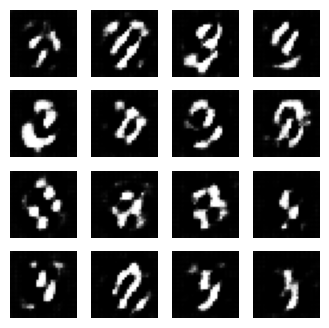

Time taken to process epoch 5 was 60.274786710739136 seconds.
Epoch:  6


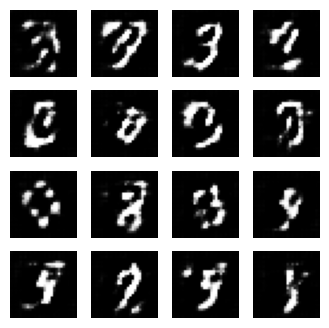

Time taken to process epoch 6 was 60.19594192504883 seconds.
Epoch:  7


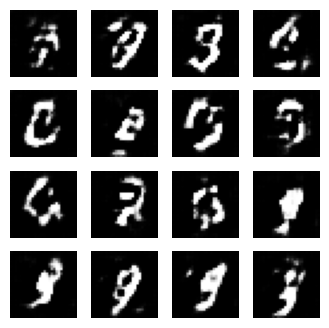

Time taken to process epoch 7 was 59.77304434776306 seconds.
Epoch:  8


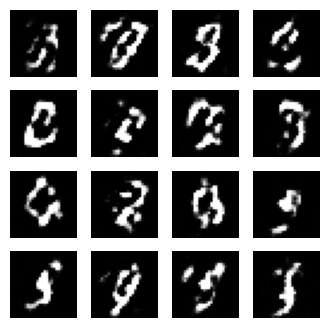

Time taken to process epoch 8 was 82.63163447380066 seconds.
Epoch:  9


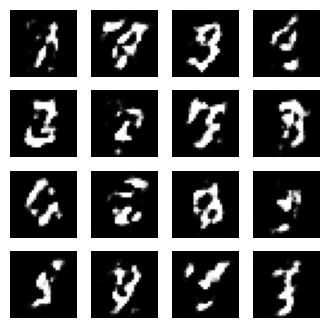

Time taken to process epoch 9 was 60.29245376586914 seconds.
Epoch:  10


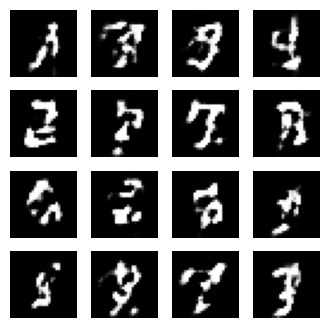

Time taken to process epoch 10 was 60.74700593948364 seconds.
Epoch:  11


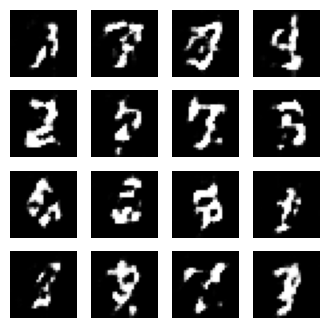

Time taken to process epoch 11 was 60.56297945976257 seconds.
Epoch:  12


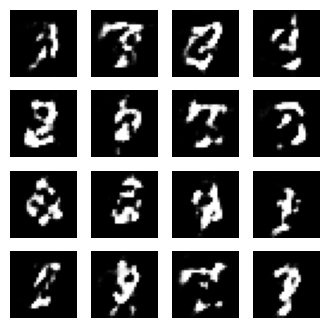

Time taken to process epoch 12 was 82.80198550224304 seconds.
Epoch:  13


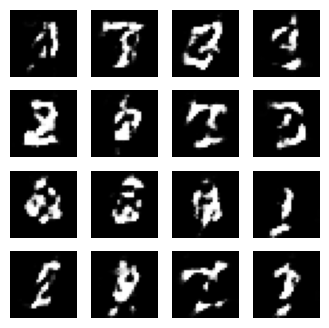

Time taken to process epoch 13 was 60.52130126953125 seconds.
Epoch:  14


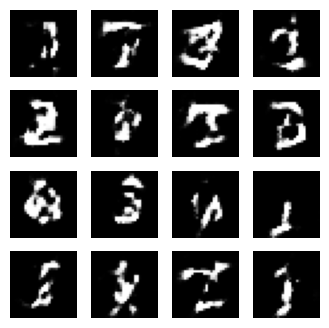

Time taken to process epoch 14 was 59.85163903236389 seconds.
Epoch:  15


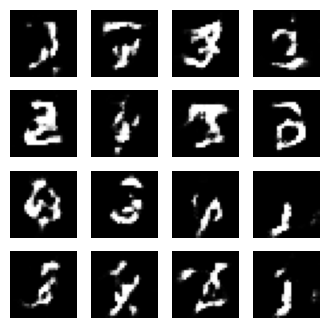

Time taken to process epoch 15 was 59.9161856174469 seconds.
Epoch:  16


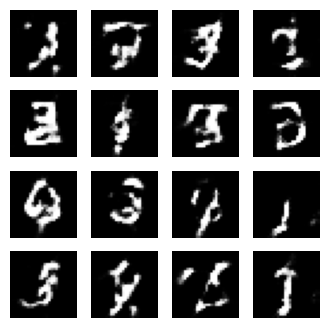

Time taken to process epoch 16 was 60.261950731277466 seconds.
Epoch:  17


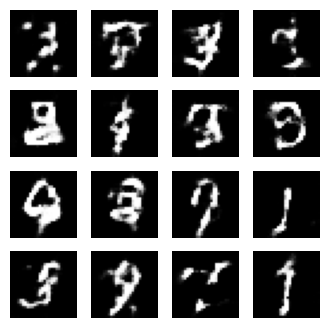

Time taken to process epoch 17 was 60.12641620635986 seconds.
Epoch:  18


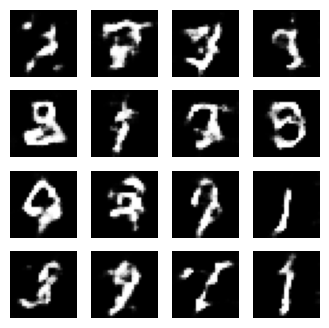

Time taken to process epoch 18 was 60.02971410751343 seconds.
Epoch:  19


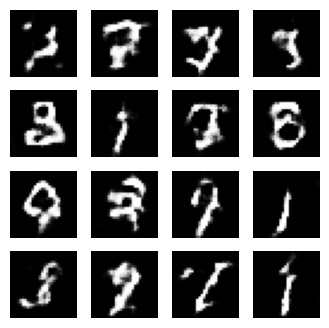

Time taken to process epoch 19 was 59.856640338897705 seconds.
Epoch:  20


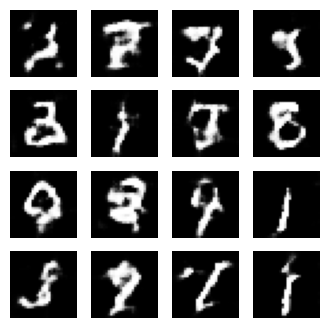

Time taken to process epoch 20 was 59.966983795166016 seconds.


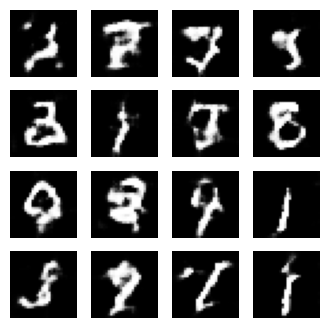

In [ ]:
train_gan(X_train, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

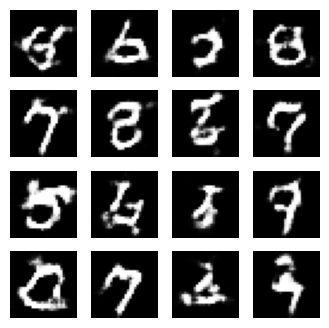

In [ ]:
seed_input = tf.random.normal([NUMBER_OF_IMAGES, NOISE_DIMENSION])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')